In [1]:
# === Imports ===
import gc
import sys
import os 
import warnings
import time
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from tensorflow.python.framework.random_seed import set_random_seed
from deep_models import FCNN
from metrics import measure_performance
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# function to sample N synthetic values and augment training data
def augment_synth_data(run_file_num, synth_amount):

    synth_data = pd.read_csv("../data/sars/" + file_name + "/" + file_name + "_run_" + str(run_file_num) + "_train.csv")

    if synth_amount == "all":
        return synth_data 
    
    elif synth_amount > 0:
        pos_sample_percentage = round(synth_amount * 0.51)  # positive label percentage
        neg_sample_percentage = synth_amount - pos_sample_percentage  # sample 33% negative samples
        
        # sample for augmentation
        positive_samples = synth_data.loc[synth_data["classLabel"] == 1] \
            .sample(n=pos_sample_percentage, replace=False)
        
        negative_samples = synth_data.loc[synth_data["classLabel"] == 0] \
            .sample(n=neg_sample_percentage, replace=False)
        
        # vertical concat -> row-wise
        return pd.concat([positive_samples, negative_samples], axis=0) 

In [3]:
# === HYPERPARAMTERS ===
_BATCH = 1
_EPOCHS = 100
_VERBOSITY = 0
criterion = EarlyStopping(monitor="loss", patience=5)
NUM_SEED = 5
NUM_RUN = 3
input_dim = 891

run_list = []
seed_list = []

# === Train Results Lists ===
train_acc_list = []
train_epochs_acc_list = []
train_bal_acc_list = []
train_loss_curves = []
train_tp_list = []
train_tn_list = []
train_fp_list = []
train_fn_list = []
train_f1_list = []
train_recall_list = []
train_precision_list = []

# === Test Results Lists ===
test_acc_list = []
test_bal_acc_list = []
test_tp_list = []
test_tn_list = []
test_fp_list = []
test_fn_list = []
test_f1_list = []
test_recall_list = []
test_precision_list = []

# synth data controllers, only 1 should be True at any time
is_blended = True
is_vae = False

# synths file names
if is_blended:
    file_name = "blended"
elif is_vae:
    file_name = "vae"
else:
    file_name = "orig"
    
# 0, amount wanted or "all"
synth_amount = 2000

In [4]:
# track training time
start_time = time.time()

for run in range(1, NUM_RUN + 1):
    print("######################### RUN %d #########################" % run)
    
    ################
    # DATA #
    ################
    
    # === DATA SOURCES ===
    run_training_file = "../data/sars/orig/orig_run_" + str(run) + "_train.csv"
    run_holdout_file = "../data/sars/orig/orig_run_" + str(run) + "_holdout.csv"
    
    training_data = pd.read_csv(run_training_file, header=0)
    
    # concat training data with current augmentation
    if is_blended or is_vae:
        synth_data = augment_synth_data(run, synth_amount)
        training_data = pd.concat([training_data, synth_data])
        
        print(f'Synth samples added: {synth_data.shape[0]}')
        del synth_data
    
    # split features and labels
    X_train = training_data.iloc[:, :-1]    
    y_train = training_data.iloc[:, -1]
    
    # holdout file
    test_data = pd.read_csv(run_holdout_file, header=0)
    X_test = test_data.iloc[:, :-1]  
    y_test = test_data.iloc[:, -1]
    
    print("Total training samples = %d" % X_train.shape[0])
    print("Total holdout samples = %d" % y_test.shape[0])

    # clean memory
    del training_data
    del test_data
    del run_training_file
    del run_holdout_file
    gc.collect()
    
    ################
    # TRAINING # 
    ################
    
    print('Run', '\t', 'Seed', '\t', 'Test Accuracy', '\t', "Balanced Test Accuracy")

    for seed in range(0, NUM_SEED):
        # reproducibility
        set_random_seed(seed)
        np.random.seed(seed)
        
        run_list.append(run)
        seed_list.append(seed)

        # import and fit model
        model = FCNN(input_dim)

        # train model
        fit = model.fit(X_train, y_train, epochs=_EPOCHS, batch_size=_BATCH,
                        shuffle=True, verbose=_VERBOSITY)
        
        train_loss_curves.append(fit.history['loss'])
        train_epochs_acc_list.append(fit.history['acc'])

        # get training metrics
        train_accuracy, train_bal_accuracy, train_precision, train_recall, \
        train_f1, train_tn, train_fp, train_fn, train_tp = measure_performance(model, X_train, y_train)
        
        # get test metrics
        test_accuracy, test_bal_accuracy, test_precision, test_recall, \
        test_f1, test_tn, test_fp, test_fn, test_tp = measure_performance(model, X_test, y_test)
        
        # update train metric lists
        train_acc_list.append(train_accuracy)
        train_bal_acc_list.append(train_bal_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)
        train_tn_list.append(train_tn)
        train_fp_list.append(train_fp)
        train_fn_list.append(train_fn)
        train_tp_list.append(train_tp)
        
        # update train metric lists
        test_acc_list.append(test_accuracy)
        test_bal_acc_list.append(test_bal_accuracy)
        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)
        test_tn_list.append(test_tn)
        test_fp_list.append(test_fp)
        test_fn_list.append(test_fn)
        test_tp_list.append(test_tp)
        
        print(run, '\t', seed, '\t', test_accuracy, '\t', test_bal_accuracy)
    
    # clear data to load fresh (cache issue in notebook)
    del X_train 
    del y_train
    del X_test
    del y_test
    del model
    del fit
    gc.collect()
        
    print()
    
print("FCNN took approx: %s minutes" % round((time.time() - start_time) / 60, 4))

######################### RUN 1 #########################
Synth samples added: 2000
Total training samples = 2103
Total holdout samples = 206
Run 	 Seed 	 Test Accuracy 	 Balanced Test Accuracy
1 	 0 	 0.8398058252427184 	 0.8443396226415094
1 	 1 	 0.8495145631067961 	 0.8537735849056604
1 	 2 	 0.8640776699029126 	 0.8679245283018868
1 	 3 	 0.8446601941747572 	 0.8490566037735849
1 	 4 	 0.8592233009708737 	 0.8632075471698113

######################### RUN 2 #########################
Synth samples added: 2000
Total training samples = 2103
Total holdout samples = 206
Run 	 Seed 	 Test Accuracy 	 Balanced Test Accuracy
2 	 0 	 0.9174757281553398 	 0.9198113207547169
2 	 1 	 0.912621359223301 	 0.914811320754717
2 	 2 	 0.912621359223301 	 0.9150943396226415
2 	 3 	 0.912621359223301 	 0.914811320754717
2 	 4 	 0.9174757281553398 	 0.9198113207547169

######################### RUN 3 #########################
Synth samples added: 2000
Total training samples = 2103
Total holdout samples

In [5]:
# === SAVE RESULTS ===
# converts results lists to dataframe
results_folder = "../results/sars/" + file_name
    
test_results = pd.DataFrame({'run': run_list, 'seed': seed_list, 'accuracy': test_acc_list, "bal_accuracy": test_bal_acc_list,
                             "precision": test_precision_list, "recall": test_recall_list, 
                             "f1": test_f1_list, "tp": test_tp_list, "fp": test_fp_list, 
                             "tn": test_tn_list, "fn": test_fn_list})

# calculates the mean accuracies and the associated standard deviation
test_means = test_results.groupby(['run'])["accuracy", "bal_accuracy", "precision", "recall", "f1"].mean()
test_standard_deviations = test_results.groupby(['run'])["accuracy", "bal_accuracy", "precision", "recall", "f1"].std()

test_means = test_means.add_prefix("mean_")
test_standard_deviations = test_standard_deviations.add_prefix("std_")

# # creates dataframe of mean and standard deviation aggregate values
test_results_summary = pd.concat([test_means.round(3), test_standard_deviations.round(3)], axis=1)

# # get mean of all 3 runs
test_results_summary.loc["run_mean"] = test_results_summary.mean().round(3)

# # Save results to File
test_results.to_csv(results_folder + "/test_fcnn_results_" + str(synth_amount) + ".csv", index=False)
test_results_summary.to_csv(results_folder + "/test_fcnn_results_summary_" + str(synth_amount) + ".csv")

In [6]:
# === SAVE RESULTS ===
# converts results lists to dataframe
results_folder = "../results/sars/" + file_name

# results from training set evaluation (not epochs)
train_results = pd.DataFrame({'run': run_list, 'seed': seed_list, 'accuracy': train_acc_list, "bal_accuracy": train_bal_acc_list,
                             "precision": train_precision_list, "recall": train_recall_list, 
                             "f1": train_f1_list, "tp": train_tp_list, "fp": train_fp_list, 
                             "tn": train_tn_list, "fn": train_fn_list})

# calculates the mean accuracies and the associated standard deviation
train_means = train_results.groupby(['run'])["accuracy", "bal_accuracy", "precision", "recall", "f1"].mean()
train_standard_deviations = train_results.groupby(['run'])["accuracy", "bal_accuracy", "precision", "recall", "f1"].std()

train_means = train_means.add_prefix("mean_")
train_standard_deviations = train_standard_deviations.add_prefix("std_")

# creates dataframe of mean and standard deviation aggregate values
train_results_summary = pd.concat([train_means.round(3), train_standard_deviations.round(3)], axis=1)
train_results_summary

# get mean of all 3 runs
train_results_summary.loc["run_mean"] = train_results_summary.mean().round(3)

# Save results to File
train_results.to_csv(results_folder + "/train_fcnn_results_" + str(synth_amount) + ".csv", index=False)
train_results_summary.to_csv(results_folder + "/train_fcnn_results_summary_" + str(synth_amount) + ".csv")

train_results_summary

,mean_accuracy,mean_bal_accuracy,mean_precision,mean_recall,mean_f1,std_accuracy,std_bal_accuracy,std_precision,std_recall,std_f1
run,,,,,,,,,,
1,1.000,1.000,1.0,1.000,1.000,0.000,0.000,0.0,0.000,0.000
2,1.000,1.000,1.0,1.000,1.000,0.000,0.000,0.0,0.000,0.000
3,0.998,0.998,1.0,0.997,0.998,0.004,0.004,0.0,0.007,0.004
run_mean,0.999,0.999,1.0,0.999,0.999,0.001,0.001,0.0,0.002,0.001


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.038091,0.000075,0.000015,0.000004,0.012978,6.319324e-07,2.270936e-07,0.033792,0.000097,0.000002,...,5.266656e-10,5.182398e-10,4.954905e-10,5.399194e-10,4.541946e-10,5.614644e-10,5.559392e-10,5.083595e-10,5.117028e-10,4.422096e-10
1,0.085732,0.032858,0.008435,0.020292,0.002561,9.923047e-03,3.706964e-03,0.015686,0.000064,0.005156,...,6.352085e-11,6.129063e-11,6.080600e-11,6.093139e-11,5.894753e-11,6.046029e-11,5.836396e-11,5.382335e-11,5.748396e-11,6.025465e-11
2,0.222346,0.070975,0.038926,0.042149,0.025261,1.534723e-02,3.316480e-02,0.018767,0.034085,0.018173,...,1.157954e-04,5.249434e-03,5.750457e-06,1.209196e-02,7.959867e-03,4.739432e-03,2.452128e-06,3.714515e-06,8.339549e-03,2.028766e-03


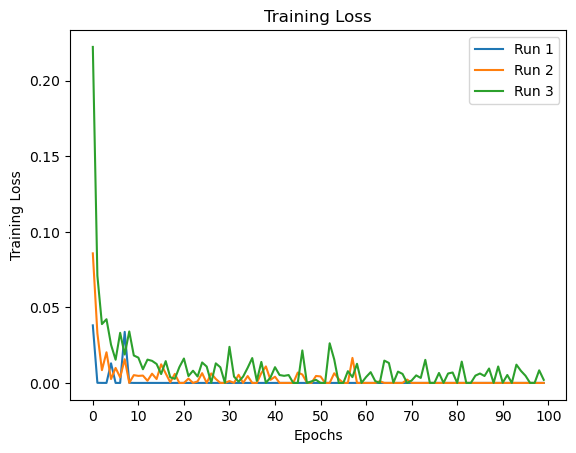

In [7]:
df_train_loss = pd.DataFrame(train_loss_curves)
df_train_loss.to_csv(results_folder + "/fcnn_train_loss_" + str(synth_amount) + ".csv", index=False)

train_loss_means = df_train_loss.groupby(np.arange(len(df_train_loss))//5).mean()

# plot training loss curves
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.xticks(range(0, _EPOCHS+1, 10))

plt.plot(train_loss_means.iloc[0, :],  label="Run 1")
plt.plot(train_loss_means.iloc[1, :], label="Run 2")
plt.plot(train_loss_means.iloc[2, :], label="Run 3")

plt.legend()
#plt.savefig(results_folder + "/fcnn_sars_" + str(synth_amount) + "_training_loss.png")

train_loss_means

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.989634,1.000000,1.000000,1.000000,0.998859,1.000000,1.000000,0.998193,0.999905,1.000000,...,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.00000
1,0.977366,0.992582,0.998098,0.996576,0.999334,0.998193,0.999144,0.996767,1.000000,0.998669,...,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.00000
2,0.926961,0.977080,0.989919,0.988398,0.993343,0.995720,0.993153,0.995055,0.992772,0.995720,...,1.0,0.999049,1.0,0.998859,0.999144,0.999524,1.0,1.0,0.998859,0.99981


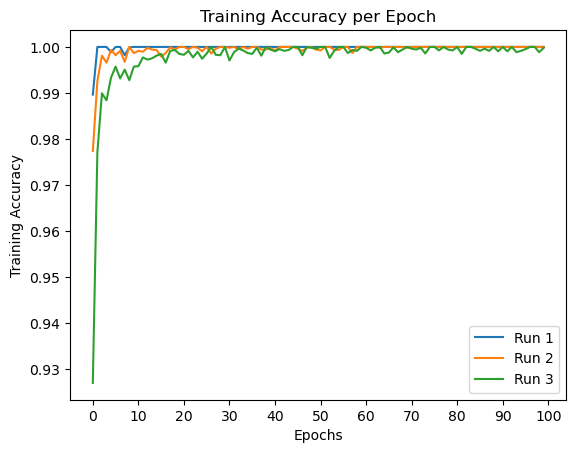

In [8]:
df_train_epoch_acc = pd.DataFrame(train_epochs_acc_list)
df_train_epoch_acc.to_csv(results_folder + "/fcnn_epoch_train_loss_" + str(synth_amount) + ".csv", index=False)

train_acc_means = df_train_epoch_acc.groupby(np.arange(len(df_train_epoch_acc))//5).mean()

# plot training acc
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.xticks(range(0, _EPOCHS+1, 10))

plt.plot(train_acc_means.iloc[0, :], label="Run 1")
plt.plot(train_acc_means.iloc[1, :], label="Run 2")
plt.plot(train_acc_means.iloc[2, :], label="Run 3")

plt.legend()
#plt.savefig(results_folder + "/fcnn_sars_" + str(synth_amount) + "_training_acc.png")

train_acc_means

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.839806,0.849515,0.864078,0.84466,0.859223,0.917476,0.912621,0.912621,0.912621,0.917476,0.800971,0.781553,0.800971,0.854369,0.800971


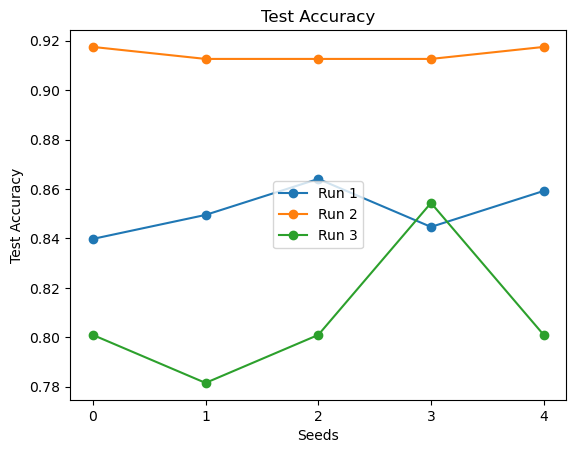

In [9]:
# plot acc curves
plt.title("Test Accuracy")
plt.xlabel("Seeds")
plt.ylabel("Test Accuracy")
plt.xticks(range(0, NUM_SEED))

plt.plot(test_acc_list[0:5], "o-", label="Run 1")
plt.plot(test_acc_list[5:10], "o-", label="Run 2")
plt.plot(test_acc_list[10:15], "o-", label="Run 3")

plt.legend()
#plt.savefig(results_folder + "/fcnn_sars_" + str(synth_amount) + "_test_acc.png")

pd.DataFrame(test_acc_list).T